### Clustering of sleep text scores using TF-IDF

#### Import libraries  

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

#### Setup working directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Documents/ds2024/dsF1/

Mounted at /content/drive
/content/drive/MyDrive/Documents/ds2024/dsF1


#### Parameters  

In [3]:
csv_in = 'sleep-text-score-wakati.csv'

#### Read CSV file  

In [4]:
df = pd.read_csv(csv_in, sep=',', skiprows=0, header=0)
print(df.shape)
print(df.info())
display(df.head())

(426, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               426 non-null    object
 1   GPT-4o             426 non-null    int64 
 2   Gemini-1.5-Pro     426 non-null    int64 
 3   Claude-3.5-Sonnet  426 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 13.4+ KB
None


,text,GPT-4o,Gemini-1.5-Pro,Claude-3.5-Sonnet
0,就寝 時間 毎日 一定 する,2,2,2
1,朝日 積極的 浴びる,2,2,2
2,寝室 温度 18 -22度 保つ,2,2,2
3,就寝 前 ストレッチ 体 リラックス さ せる,2,2,2
4,寝具 定期的 清潔 保つ,2,2,2


In [5]:
df = df[['text', 'GPT-4o']]
print(df.shape)
print(df.info())
display(df.head())

(426, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    426 non-null    object
 1   GPT-4o  426 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.8+ KB
None


,text,GPT-4o
0,就寝 時間 毎日 一定 する,2
1,朝日 積極的 浴びる,2
2,寝室 温度 18 -22度 保つ,2
3,就寝 前 ストレッチ 体 リラックス さ せる,2
4,寝具 定期的 清潔 保つ,2


#### Check the number of documents in each category  

In [6]:
print(df['GPT-4o'].value_counts().sort_index(ascending=True))

GPT-4o
0    164
1     61
2    201
Name: count, dtype: int64


#### Calculation of TF-IDF

In [8]:
vectorizer = TfidfVectorizer(use_idf=True)
tfidf_obj = vectorizer.fit_transform(df['text'])

#### Check word set

In [9]:
vocab = vectorizer.get_feature_names_out()
print('Vocabulary size:', len(vocab))
print(vocab[:10])
print(vocab[-10:])

Vocabulary size: 610
['10時' '18' '1日' '1時間' '1時間前' '20分' '22度' '22時' '24時間' '2時間']
['食事' '食物繊維' '飲み物' '飲む' '飲料' '香り' '騒音' '高い' '高く' '高得点']


#### Obtain TF-IDF as a list

In [10]:
tfidf = tfidf_obj.toarray()
print(tfidf.shape)

(426, 610)


#### Typical text for each label

In [12]:
for label in [0, 1, 2]:
    print(f"\nTop 10 typical texts for Label {label}:")
    print("-" * 50)

    mask = df['GPT-4o'] == label
    label_tfidf = tfidf[mask]
    label_texts = df[mask]['text']

    similarities = cosine_similarity(label_tfidf)

    centrality_scores = np.mean(similarities, axis=1)

    top_indices = np.argsort(centrality_scores)[-10:][::-1]

    for i, idx in enumerate(top_indices, 1):
        score = centrality_scores[idx]
        print(f"{i}. {label_texts.iloc[idx]} (Score: {score:.3f})")


Top 10 typical texts for Label 0:
--------------------------------------------------
1. 寝る 直前 激しい 運動 する (Score: 0.085)
2. 寝る 直前 カフェイン 摂取 する (Score: 0.082)
3. 寝室 仕事 する (Score: 0.080)
4. 寝る 前 激しい 運動 する (Score: 0.076)
5. 寝る 前 議論 する (Score: 0.067)
6. 寝る 直前 強い 運動 する (Score: 0.067)
7. 寝室 仕事 電話 する (Score: 0.067)
8. 就寝 前 激しい カフェイン 摂取 する (Score: 0.065)
9. 寝室 仕事 し 続ける (Score: 0.064)
10. カフェイン 夜遅く 摂取 する (Score: 0.063)

Top 10 typical texts for Label 1:
--------------------------------------------------
1. 就寝 前 軽い テレビ番組 見る (Score: 0.069)
2. 軽い テレビ番組 寝る 前 見る (Score: 0.067)
3. 就寝 前 短時間 テレビ 視聴 (Score: 0.065)
4. 就寝 前 短時間 SNS チェック (Score: 0.061)
5. 寝る 前 短い 電話 する (Score: 0.060)
6. 寝室 物 する (Score: 0.055)
7. 就寝 前 長時間 電話 (Score: 0.051)
8. 寝る 前 興奮 する 動画 視聴 (Score: 0.050)
9. 寝る 前 メール チェック し 返信 する (Score: 0.049)
10. 夕方 以降 軽い 家事 (Score: 0.048)

Top 10 typical texts for Label 2:
--------------------------------------------------
1. 寝る 前 軽い 散歩 する (Score: 0.073)
2. 寝る 前 軽い 読書 する (Score: 0.070)
3. 寝る 前 軽い ジャーナリング

#### Elbow method to determine the number of clusters  

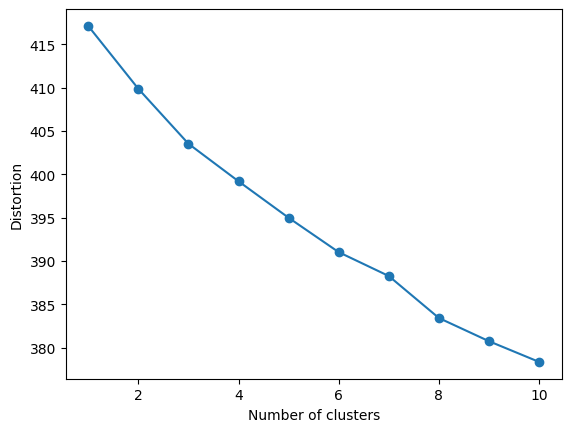

CPU times: user 1.82 s, sys: 1.73 s, total: 3.55 s
Wall time: 3.55 s


In [13]:
%%time

max_cls = 10
distortions = []
for i in range(1, max_cls+1):
    km = KMeans(n_clusters=i, n_init=10)
    km.fit(tfidf)
    distortions.append(km.inertia_)
plt.plot(range(1, max_cls+1), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

#### K-Means clustering  

In [14]:
n_cls = 3
km = KMeans(n_clusters=n_cls, n_init=10, random_state=7)
cls = km.fit_predict(tfidf)

#### Check correspondence of target and clusters  

In [15]:
display(pd.crosstab(df['GPT-4o'], cls))

col_0,0,1,2
GPT-4o,,,
0,91,23,50
1,39,5,17
2,142,21,38


#### PCA  

In [16]:
%%time

pca = PCA(n_components=2)
Y_pca = pca.fit_transform(tfidf)

CPU times: user 22 ms, sys: 30.6 ms, total: 52.6 ms
Wall time: 38.2 ms


#### Check contribution ratio  

In [17]:
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))

[0.020417   0.01810374]
[0.020417   0.03852074]


#### Plot of PCA colored by cluster ID

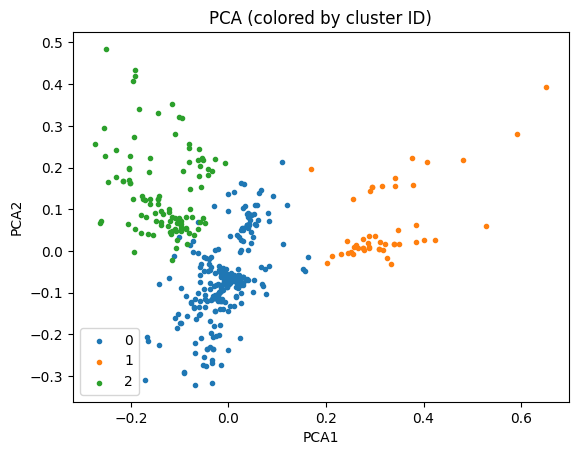

In [18]:
plt.title("PCA (colored by cluster ID)")
marker = '.'
for i in range(n_cls):
    y1 = Y_pca[ cls==i ]
    plt.scatter(y1[:, 0], y1[:, 1], marker=marker, label=i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

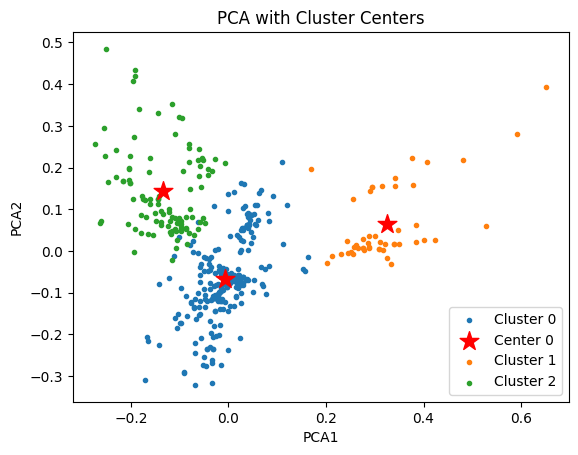


Cluster 0 - Texts near center (within distance 0.05):
--------------------------------------------------------------------------------
Distance 0.002: 日光 浴びる
Distance 0.003: リビング 眠る
Distance 0.003: 毎朝 時間 起きる
Distance 0.003: 朝陽 浴びる
Distance 0.004: 部屋 香り 豊か アロマ 満たす
Distance 0.004: 朝日 積極的 浴びる
Distance 0.005: マグネシウム 多く 含む アーモンド ナッツ類 間食 取り入れる
Distance 0.006: 軽く 目 閉じ 深呼吸 し 心 落ち着ける
Distance 0.006: 寝る時間 明日 楽しい 計画 心 留める
Distance 0.006: 友達 楽しい 時間 過ごす
Distance 0.008: 夜 シャワー
Distance 0.008: ホット タオル 首 温める
Distance 0.008: 明日へ 楽しい 計画 立てる
Distance 0.009: 日中 いる 場所 ところ いる
Distance 0.010: 帰宅 遅く なる
Distance 0.010: 負の感情 抱え まま 眠る
Distance 0.010: 夜遅く 食べ 過ぎる
Distance 0.010: 朝 早く 起き 日光 感じる
Distance 0.010: ポジティブシンキング 心掛ける
Distance 0.010: 自然 音 聞く
Distance 0.010: 外 騒音 光 気 なっ 眠れ
Distance 0.010: パートナー いびき 寝言 うるさい
Distance 0.011: 週末 長め 昼寝 取る
Distance 0.011: 週末 寝る時間 遅らせる
Distance 0.011: アロマキャンドル 焚く
Distance 0.011: 夜 過度 情報収集
Distance 0.011: 朝 タイマー セット しない 目覚める
Distance 0.011: 人混み 行く
Distance 0.012: ソフト 肌触り 良い パジャマ 着る

In [19]:
def find_texts_near_center_pca(pca_coords, texts, labels, cluster_id, distance_threshold):
    # Get points for the specified cluster
    cluster_mask = labels == cluster_id
    cluster_coords = pca_coords[cluster_mask]
    cluster_texts = texts[cluster_mask]

    # Find cluster center
    center = np.mean(cluster_coords, axis=0)

    # Calculate distances from center
    distances = np.sqrt(np.sum((cluster_coords - center) ** 2, axis=1))

    # Find points within threshold
    nearby_mask = distances <= distance_threshold
    nearby_texts = cluster_texts[nearby_mask]
    nearby_distances = distances[nearby_mask]

    # Sort by distance
    sorted_indices = np.argsort(nearby_distances)
    sorted_texts = nearby_texts[sorted_indices]
    sorted_distances = nearby_distances[sorted_indices]

    return sorted_texts, sorted_distances, center

# Convert texts to numpy array for indexing
texts_array = np.array(df['text'])

# Plot PCA with cluster centers
plt.title("PCA with Cluster Centers")
marker = '.'

for i in range(n_cls):
    y1 = Y_pca[cls==i]
    plt.scatter(y1[:, 0], y1[:, 1], marker=marker, label=f'Cluster {i}')

    # Find and plot cluster center
    center = np.mean(y1, axis=0)
    plt.scatter(center[0], center[1], marker='*', s=200,
               c='red', label=f'Center {i}' if i==0 else "")

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

# Find nearby texts for each cluster
# Note: You might need to adjust the distance threshold for PCA
# as the scale might be different from t-SNE
distance_threshold = 0.05  # Adjust this value based on your PCA scale

for cluster_id in range(n_cls):
    print(f"\nCluster {cluster_id} - Texts near center (within distance {distance_threshold}):")
    print("-" * 80)

    nearby_texts, distances, center = find_texts_near_center_pca(
        Y_pca, texts_array, cls, cluster_id, distance_threshold
    )

    for text, dist in zip(nearby_texts, distances):
        print(f"Distance {dist:.3f}: {text}")

LLM は文章の先を見ている（だから何なのか）  
Clustering は文章そのものを見ている（Cluster1: 寝室, Cluster2: 寝る前, Cluster0: それ以外）

#### Plot of PCA colored by target  

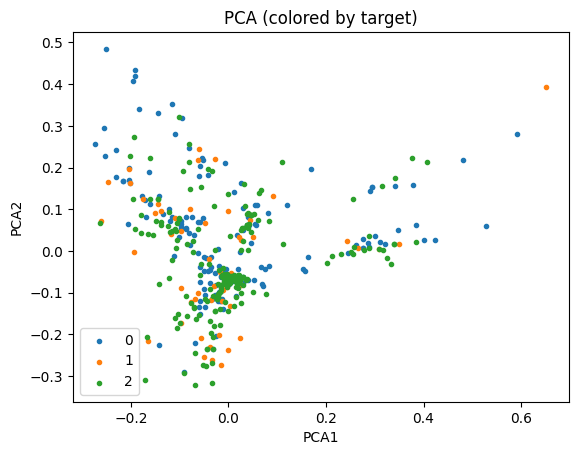

In [20]:
#plt.figure(figsize=(10,7))
plt.title("PCA (colored by target)")
marker = '.'
for i in range(n_cls):
    y1 = Y_pca[ df['GPT-4o']==i ]
    plt.scatter(y1[:, 0], y1[:, 1], marker=marker, label=i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

#### t-SNE  

In [21]:
%%time

Y_tsne = TSNE(n_components=2,
              perplexity=30, n_iter=500,
              random_state=0).fit_transform(tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


CPU times: user 1.91 s, sys: 109 ms, total: 2.02 s
Wall time: 1.89 s


#### Plot of t-SNE colored by cluster ID

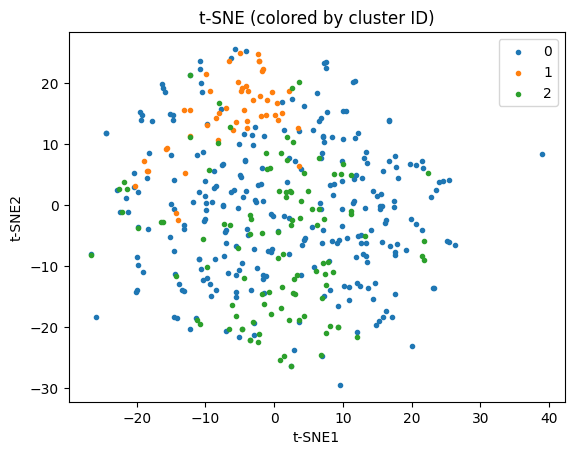

In [22]:
#plt.figure(figsize=(10,7))
plt.title("t-SNE (colored by cluster ID)")
marker = '.'
for i in range(n_cls):
    y1 = Y_tsne[ cls==i ]
    plt.scatter(y1[:, 0], y1[:, 1], marker=marker, label=i)

plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()
plt.show()

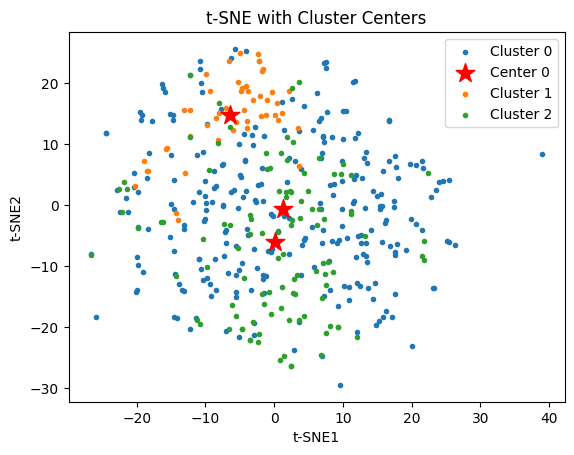


Cluster 0 - Texts near center (within distance 5.0):
--------------------------------------------------------------------------------
Distance 1.09: 毎朝 時間 起きる
Distance 1.78: 毎晩 時間 ベッド 入り 朝 決まっ 時間 起きる こと 習慣 化 する
Distance 1.79: 不規則 就寝 時間
Distance 1.90: 就寝 時間 毎日 一定 する
Distance 3.14: 軽く 目 閉じ 深呼吸 し 心 落ち着ける
Distance 3.60: 休日 平日 時間 起床 する
Distance 4.06: 就寝 前 深呼吸 取り入れる
Distance 4.28: 就寝 前 深呼吸 リラックス する
Distance 4.40: 24時間 ジム 夜 訪問 する 軽 め 運動 留める

Cluster 1 - Texts near center (within distance 5.0):
--------------------------------------------------------------------------------
Distance 1.38: 寝室 明る さ 調整 せ 寝る
Distance 1.39: 寝室 片付け 放置 する
Distance 1.69: 寝室 照明 調整 する
Distance 2.15: 寝室 電子機器 置か
Distance 2.17: 寝室 照明 暖色系 する
Distance 2.50: 寝室 クローゼット 開けっぱなし する
Distance 2.65: 寝室 通気 悪く する
Distance 3.25: 寝室 物 する
Distance 3.69: 寝室 明るい 照明 使う
Distance 4.22: 寝室 消音 し テレビ 見る
Distance 4.31: 寝室 観葉植物 置く
Distance 4.45: 寝室 窓 閉め切っ 換気 し
Distance 4.49: 寝室 加湿器 設置 する
Distance 4.73: 寝室 テレビ 置く
Distance 4.90: 寝室 ピンクソルトランプ 置く
Dis

In [23]:
def find_texts_near_center(tsne_coords, texts, labels, cluster_id, distance_threshold):
    # Get points for the specified cluster
    cluster_mask = labels == cluster_id
    cluster_coords = tsne_coords[cluster_mask]
    cluster_texts = texts[cluster_mask]

    # Find cluster center
    center = np.mean(cluster_coords, axis=0)

    # Calculate distances from center
    distances = np.sqrt(np.sum((cluster_coords - center) ** 2, axis=1))

    # Find points within threshold
    nearby_mask = distances <= distance_threshold
    nearby_texts = cluster_texts[nearby_mask]
    nearby_distances = distances[nearby_mask]

    # Sort by distance
    sorted_indices = np.argsort(nearby_distances)
    sorted_texts = nearby_texts[sorted_indices]
    sorted_distances = nearby_distances[sorted_indices]

    return sorted_texts, sorted_distances, center

# Convert texts to numpy array for indexing
texts_array = np.array(df['text'])

# Plot t-SNE with cluster centers
plt.title("t-SNE with Cluster Centers")
marker = '.'

for i in range(n_cls):
    y1 = Y_tsne[cls==i]
    plt.scatter(y1[:, 0], y1[:, 1], marker=marker, label=f'Cluster {i}')

    # Find and plot cluster center
    center = np.mean(y1, axis=0)
    plt.scatter(center[0], center[1], marker='*', s=200,
               c='red', label=f'Center {i}' if i==0 else "")

plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()
plt.show()

# Find nearby texts for each cluster
distance_threshold = 5.0  # Adjust this value to control the radius

for cluster_id in range(n_cls):
    print(f"\nCluster {cluster_id} - Texts near center (within distance {distance_threshold}):")
    print("-" * 80)

    nearby_texts, distances, center = find_texts_near_center(
        Y_tsne, texts_array, cls, cluster_id, distance_threshold
    )

    for text, dist in zip(nearby_texts, distances):
        print(f"Distance {dist:.2f}: {text}")

#### Plot of t-SNE colored by target  

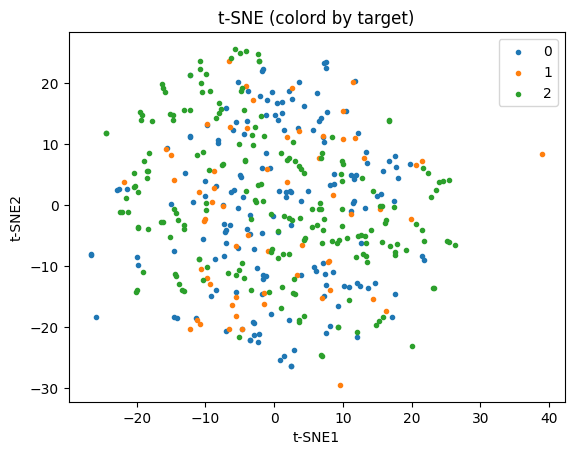

In [24]:
#plt.figure(figsize=(10,7))
plt.title("t-SNE (colord by target)")
marker = '.'
for i in range(n_cls):
    y1 = Y_tsne[ df['GPT-4o']==i ]
    plt.scatter(y1[:, 0], y1[:, 1], marker=marker, label=i)

plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()
plt.show()